<div class="alert alert-block alert-warning">
<b>Costs:</b> This QPU simulation costs $0 US dollars.
</div>

<div class="alert alert-block alert-success">
<b>This simulation finds ground state energy for H2 molecule. </b>
<div>Obs. 1: The data is saved in external files so that it can be worked on without incurring new costs.</div>
<div>Obs. 2: For new simulation parameters, save in a file with a different name.</div>
</div>

# Instructions if you are running outside AWS cloud

1. Install aws-cli:

`sudo apt install aws-cli`

2. Setup aws credentials:

`aws configure --profile "default"`

3. Create virtual environment 

`python -m venv /path/to/new/virtual/environment`

4. Activate virtual environment

`source /path/to/new/virtual/environment/bin/activate`

In [99]:
from boto3 import Session
from braket.aws import AwsSession

# Start Boto3 Session with your credentials profile
boto_session = Session(profile_name='default')

# Initialize Braket session with Boto3 Session credentials
aws_session = AwsSession(boto_session=boto_session)

# Defining the function to save results to json file and read results from file

In [2]:
import json

def save_to_file(data, file_name):
    with open(file_name+".json", "w") as file:
        json.dump(data, file, indent=4)

def read_from_file(file_name):
    with open(file_name+".json", 'r') as file:
        data = json.load(file)
    return data

# PES H2

In [29]:
# PES H2
import pennylane as qml
from pennylane import qchem

# Hartree-Fock state
hf = qml.qchem.hf_state(electrons=2, orbitals=4)

print(hf)

from pennylane import numpy as np

# atomic symbols defining the molecule
symbols = ['H', 'H']

# list to store energies
energies = []

# set up a loop to change bond length
r_range = np.arange(0.5, 2.0, 0.1)

# keeps track of points in the potential energy surface
pes_point = 0

energies   = []
r_vals_ang = []

theta_prev = None  # warm start
steps      = 120
stepsize   = 0.2

[1 1 0 0]


### Otimizacao

In [30]:

for r in r_range:
    # geometria (Å)


    ANG_TO_BOHR = 1 / 0.529177210903

    coordinates_bohr = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r]) * ANG_TO_BOHR
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates_bohr, method="pyscf")

    # pegue as excitações da API e **use só a dupla**
    try:
        singles, doubles = qchem.excitations(2, n_qubits)   # API nova
    except TypeError:
        exc = qchem.excitations(2, n_qubits)                # API antiga
        singles  = [e for e in exc if len(e) == 2]
        doubles  = [e for e in exc if len(e) == 4]

    if len(doubles) == 0:
        raise RuntimeError("Não achei a dupla excitação para H2.")

    # única dupla excitação relevante (FCI em sto-3g)
    d = doubles[0]  # ex.: [0,1,2,3] (occ α,occ β -> virt α,virt β)

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="autograd")
    def vqe(θ):
        # estado de referência HF
        qml.BasisState(hf, wires=range(n_qubits))
        # UCCD 1-parâmetro
        qml.DoubleExcitation(θ[0], wires=d)
        return qml.expval(H)

    # 1 parâmetro
    theta = np.array([0.0]) if theta_prev is None else theta_prev.copy()

    opt = qml.GradientDescentOptimizer(stepsize=stepsize)
    prev_E = 1e9
    for _ in range(steps):
        theta, E = opt.step_and_cost(vqe, theta)
        if abs(E - prev_E) < 1e-7:
            break
        prev_E = E

    theta_prev = theta  # warm start
    energies.append(float(E))
    r_vals_ang.append(float(r))

/var/folders/g1/_sv3n23d2yq5w04jzglv_r580000gn/T/ipykernel_11672/78013344.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


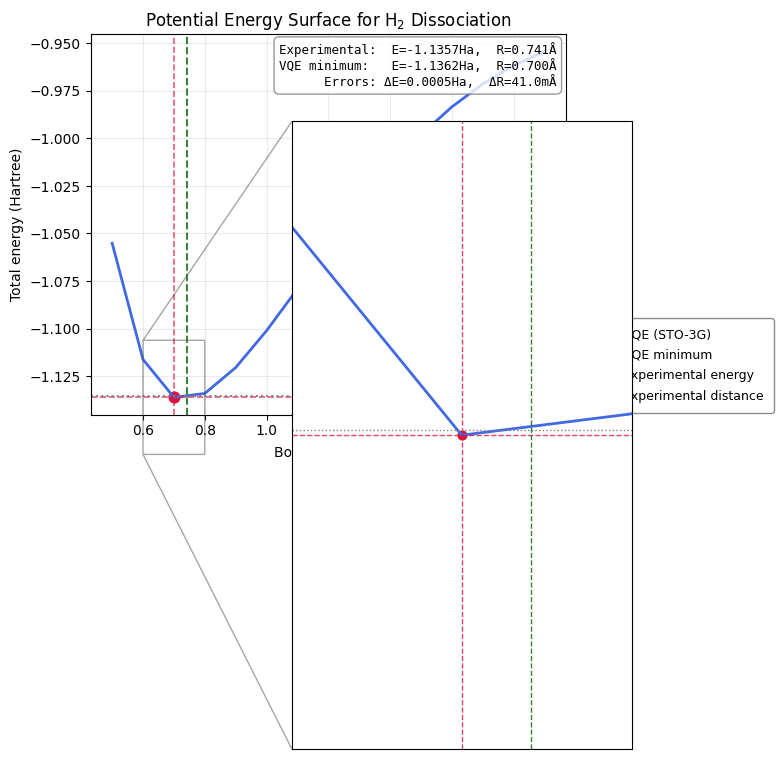

Equilibrium bond length: 0.700 Å
Minimum energy: -1.136189 Hartree
Dissociation energy ΔE: 0.181851 Hartree
Errors relative to experiment: ΔE = 0.00049 Eh, ΔR = 41.0 mÅ


In [31]:
# Arrays para plot
energies_np = np.asarray(energies, dtype=float)
r_np_ang = np.asarray(r_vals_ang, dtype=float)

# ======================================================
# 3) Plot do resultado
# ======================================================

# Referência experimental (em Å e Hartree)
E_exp = -1.1357
R_exp_ang = 0.741

# Mínimo do VQE
e_eq = float(np.min(energies_np))
idx = int(np.argmin(energies_np))
bond_length_ang = float(r_np_ang[idx])

# Erros relativos
err_E = abs(e_eq - E_exp)
err_R = abs(bond_length_ang - R_exp_ang)

# ======================================================
# Gráfico principal
# ======================================================
fig, ax = plt.subplots(figsize=(7.5, 4.8))
ax.plot(r_np_ang, energies_np, lw=2, color="royalblue", label="VQE (STO-3G)")

# Marcadores do mínimo
ax.scatter(bond_length_ang, e_eq, color="crimson", s=60, label="VQE minimum")
ax.axvline(bond_length_ang, ls="--", lw=1.2, color="crimson", alpha=0.7)
ax.axhline(e_eq, ls="--", lw=1.2, color="crimson", alpha=0.7)

# Linhas experimentais
ax.axhline(E_exp, color="gray", ls=":", lw=1.4, label="Experimental energy")
ax.axvline(R_exp_ang, color="darkgreen", ls="--", lw=1.4, alpha=0.8, label="Experimental distance")

# Caixa de texto
legend_text = (
    f"Experimental:  E={E_exp:+.4f}Ha,  R={R_exp_ang:.3f}Å\n"
    f"VQE minimum:   E={e_eq:+.4f}Ha,  R={bond_length_ang:.3f}Å\n"
    f"Errors: ΔE={err_E:.4f}Ha,  ΔR={err_R*1000:.1f}mÅ"
)
ax.text(
    0.98, 0.98, legend_text, transform=ax.transAxes, fontsize=9, family="monospace",
    va="top", ha="right", bbox=dict(boxstyle="round,pad=0.4", facecolor="white",
    alpha=0.8, edgecolor="gray")
)

# ======================================================
# Inset de zoom horizontal
# ======================================================
dx, dy = 0.1, 0.03

axins = zoomed_inset_axes(ax, zoom=5.5, loc="upper left",
                          bbox_to_anchor=(0.40, 0.80),
                          bbox_transform=ax.transAxes, borderpad=0.8)

axins.plot(r_np_ang, energies_np, lw=2, color="royalblue")
axins.scatter(bond_length_ang, e_eq, color="crimson", s=40)
axins.axvline(bond_length_ang, ls="--", lw=1.0, color="crimson", alpha=0.8)
axins.axhline(e_eq, ls="--", lw=1.0, color="crimson", alpha=0.8)
axins.axhline(E_exp, color="gray", ls=":", lw=1.0)
axins.axvline(R_exp_ang, color="darkgreen", ls="--", lw=1.0, alpha=0.8)

axins.set_xlim(bond_length_ang - dx, bond_length_ang + dx)
axins.set_ylim(e_eq - dy, e_eq + dy)
axins.tick_params(labelleft=False, labelbottom=False, length=0)
_ = ax.indicate_inset_zoom(axins, edgecolor="0.3", lw=1.0)

# Layout final
ax.set_xlabel("Bond length (Å)")
ax.set_ylabel("Total energy (Hartree)")
ax.set_title("Potential Energy Surface for H$_2$ Dissociation")
ax.legend(frameon=True, fontsize=9, loc="upper right", bbox_to_anchor=(1.45, 0.27),
          labelspacing=0.6, handlelength=2.5, handletextpad=0.8, borderpad=0.8,
          facecolor="white", edgecolor="gray", framealpha=0.9)
ax.grid(alpha=0.25)
ax.set_box_aspect(0.8)
plt.tight_layout()
plt.show()

# ======================================================
# 4) Resumo no terminal
# ======================================================
print(f"Equilibrium bond length: {bond_length_ang:.3f} Å")
print(f"Minimum energy: {e_eq:.6f} Hartree")
print(f"Dissociation energy ΔE: {energies_np[-1] - e_eq:.6f} Hartree")
print(f"Errors relative to experiment: ΔE = {err_E:.5f} Eh, ΔR = {err_R*1000:.1f} mÅ")

[1 1 1 1 0 0 0 0]


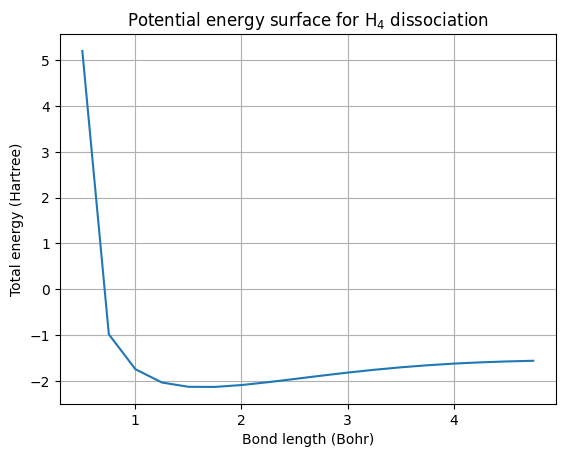

The equilibrium bond length is 1.8 Bohrs
The bond dissociation energy is 0.571056 Hartrees
The equilibrium bond length is 0.9525189796254 Angstrom


In [33]:
# PES H4
import pennylane as qml
from pennylane import qchem

# Hartree-Fock state
hf = qml.qchem.hf_state(electrons=4, orbitals=8)

print(hf)

from pennylane import numpy as np

# atomic symbols defining the molecule
symbols = ['H', 'H', 'H', 'H']

# list to store energies
energies = []

# set up a loop to change bond length
r_range = np.arange(0.5, 5.0, 0.25)

# keeps track of points in the potential energy surface
pes_point = 0

for r in r_range:
    # Change only the z coordinate of one atom
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r, 0.0, 0.0, 2*r, 0.0, 0.0, 3*r])

    # Obtain the qubit Hamiltonian
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method='pyscf')

    # define the device, optimizer and circuit
    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    @qml.qnode(dev, interface='autograd')
    def circuit(parameters):
        # Prepare the HF state: |11110000>
        qml.BasisState(hf, wires=range(qubits))
        qml.DoubleExcitation(parameters[0], wires=[0, 1, 4, 5])
        qml.DoubleExcitation(parameters[1], wires=[2, 3, 6, 7])
        qml.SingleExcitation(parameters[2], wires=[0, 4])
        qml.SingleExcitation(parameters[3], wires=[1, 5])
        qml.SingleExcitation(parameters[4], wires=[2, 6])
        qml.SingleExcitation(parameters[5], wires=[3, 7])

        return qml.expval(H)  # we are interested in minimizing this expectation value

    # initialize the gate parameters
    params = np.zeros(6, requires_grad=True)

    # initialize with converged parameters from previous point
    if pes_point > 0:
        params = params_old

    prev_energy = 0.0
    for n in range(50):
        # perform optimization step
        params, energy = opt.step_and_cost(circuit, params)

        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1

    energies.append(energy)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Bond length (Bohr)",
    ylabel="Total energy (Hartree)",
    title="Potential energy surface for H$_4$ dissociation",
)
ax.grid()
plt.show()

#Let’s use our results to compute the equilibrium bond length and the bond dissociation energy:

# equilibrium energy
e_eq = min(energies)
# energy when atoms are far apart
e_dis = energies[-1]

# Bond dissociation energy
bond_energy = e_dis - e_eq

# Equilibrium bond length
idx = energies.index(e_eq)
bond_length = r_range[idx]

print(f"The equilibrium bond length is {bond_length:.1f} Bohrs")
print(f"The bond dissociation energy is {bond_energy:.6f} Hartrees")

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903
bond_angs = 1.8 * bohr_angs
print(f"The equilibrium bond length is {bond_angs} Angstrom")

[1 1 0 0]


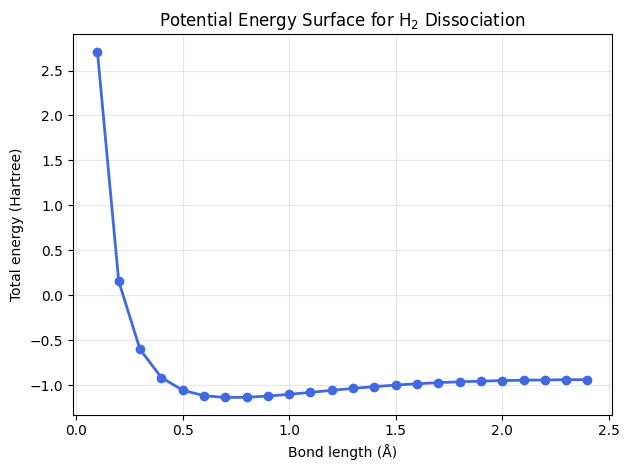

The equilibrium bond length is 0.700 Å
The bond dissociation energy is 0.198937 Hartrees


In [36]:
# PES H2 — gráfico e dados em Å
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Hartree–Fock state (H2 → 2 elétrons em 4 orbitais de spin)
hf = qml.qchem.hf_state(electrons=2, orbitals=4)
print(hf)

# Molécula H2
symbols = ['H', 'H']

energies = []
bohr_to_ang = 0.529177210903  # fator de conversão
r_range_ang = np.arange(0.1, 2.5, 0.1)   # valores em Å
r_range_bohr = r_range_ang / bohr_to_ang  # converte para Bohr p/ o PySCF

pes_point = 0

for r_bohr in r_range_bohr:
    # Geometria em Bohr: H(0,0,0), H(0,0,r)
    coordinates = np.array([0.0, 0.0, 0.0,  0.0, 0.0, r_bohr])

    # Hamiltoniano de segunda quantização
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method='pyscf')

    # device, otimizador e circuito
    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    @qml.qnode(dev, interface='autograd')
    def circuit(parameters):
        # |1100>
        qml.BasisState(hf, wires=range(qubits))
        # Ansatz simples: uma dupla + dois singles (compatível com 4 qubits)
        qml.DoubleExcitation(parameters[0], wires=[0, 1, 2, 3])
        qml.SingleExcitation(parameters[1], wires=[0, 2])
        qml.SingleExcitation(parameters[2], wires=[1, 3])
        return qml.expval(H)

    # parâmetros (warm-start)
    params = np.zeros(3, requires_grad=True)
    if pes_point > 0:
        params = params_old

    prev_energy = 0.0
    for n in range(50):
        params, energy = opt.step_and_cost(circuit, params)
        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # guarda e avança
    params_old = params
    pes_point += 1
    energies.append(float(energy))

# ======== Gráfico em Å ========
fig, ax = plt.subplots()
ax.plot(r_range_ang, energies, marker='o', lw=2, color='royalblue')
ax.set(
    xlabel="Bond length (Å)",
    ylabel="Total energy (Hartree)",
    title="Potential Energy Surface for H$_2$ Dissociation",
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======== Métricas ========
e_eq = min(energies)         # energia no mínimo
e_dis = energies[-1]         # energia dissociada (ponto mais distante)
bond_energy = e_dis - e_eq

idx = energies.index(e_eq)
bond_length_ang = r_range_ang[idx]   # já em Å

print(f"The equilibrium bond length is {bond_length_ang:.3f} Å")
print(f"The bond dissociation energy is {bond_energy:.6f} Hartrees")